In [1]:
import numpy as np
np.random.seed(0)
import itertools
import matplotlib.pyplot as plt
import numpy as np
import heapq
import random
import datetime
# Function to calculate the Euclidean distance between two points
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

In [2]:
import matplotlib.pyplot as plt

def plot_tsp_path(optimal_path, optimal_distance, coordinates, title):
    # Balanced figure size
    fig, ax = plt.subplots(figsize=(8, 6))  

    # Plot cities and labels
    for i, coord in enumerate(coordinates):
        ax.scatter(coord[0], coord[1], color='blue')
        ax.text(coord[0] + 0.5, coord[1] + 0.5, f"City {i}", fontsize=8)

    # Plot edges for TSP path
    for seq_num in range(len(optimal_path)):
        start_city = optimal_path[seq_num]
        end_city = optimal_path[(seq_num + 1) % len(optimal_path)]
        ax.plot([coordinates[start_city][0], coordinates[end_city][0]],
                [coordinates[start_city][1], coordinates[end_city][1]], 'r-')

        # Midpoint edge labeling
        mid_x = (coordinates[start_city][0] + coordinates[end_city][0]) / 2
        mid_y = (coordinates[start_city][1] + coordinates[end_city][1]) / 2
        edge_distance = euclidean_distance(coordinates[start_city], coordinates[end_city])
        ax.text(mid_x, mid_y, f"({edge_distance:.2f})", fontsize=7, color='purple')

    # Set axis limits tightly
    x_coords, y_coords = zip(*coordinates)
    ax.set_xlim(min(x_coords) - 1, max(x_coords) + 1)
    ax.set_ylim(min(y_coords) - 1, max(y_coords) + 1)

    # Title and grid
    ax.set_title(f"Optimal TSP Path with {title} algorithm. Distance: {optimal_distance:.2f}", fontsize=10)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.grid(True)  # Enable grids

    # Remove whitespace
    plt.tight_layout(pad=1.0)
    plt.show()


In [3]:
# Brute Force
# Function to calculate the total distance for a given path
def calculate_total_distance(path, coordinates):
    total_distance = 0
    for i in range(len(path) - 1):
        total_distance += euclidean_distance(coordinates[path[i]], coordinates[path[i + 1]])
    total_distance += euclidean_distance(coordinates[path[-1]], coordinates[path[0]])  # Return to the starting point
    return total_distance

# Brute force TSP solution
def tsp_brute_force(coordinates):
    n = len(coordinates)
    cities = list(range(n))
    min_path = None
    min_distance = float('inf')

    for perm in itertools.permutations(cities):
        current_distance = calculate_total_distance(perm, coordinates)
        if current_distance < min_distance:
            min_distance = current_distance
            min_path = perm

    return min_path, min_distance



In [4]:

# Branch and Bound

# Helper function to calculate the initial cost matrix and minimum edge costs for bounding
def create_cost_matrix(coordinates):
    n = len(coordinates)
    matrix = np.array([[euclidean_distance(coordinates[i], coordinates[j]) for j in range(n)] for i in range(n)])
    min_edge_cost = [min(row[i] for i in range(n) if i != j) for j, row in enumerate(matrix)]
    return matrix, min_edge_cost

# Branch and Bound TSP solution using a priority queue
def tsp_branch_and_bound(coordinates):
    n = len(coordinates)
    matrix, min_edge_cost = create_cost_matrix(coordinates)

    # Initialize the priority queue with (bound, cost, current path, visited cities)
    pq = []
    initial_bound = sum(min_edge_cost)  # Initial lower bound using minimum edges
    initial_path = [0]  # Start from city 0
    initial_visited = [False] * n
    initial_visited[0] = True  # Mark city 0 as visited

    # Push the initial state to the priority queue
    heapq.heappush(pq, (initial_bound, 0, initial_path, initial_visited))
    min_distance = float('inf')
    min_path = []

    # Explore paths using priority queue for best-first traversal
    while pq:
        bound, cost, path, visited = heapq.heappop(pq)

        # Skip this path if the bound is already worse than the best known solution
        if bound >= min_distance:
            continue

        # Get the last city in the current path
        last_city = path[-1]

        # If we have visited all cities, complete the path by returning to the starting city
        if len(path) == n:
            total_cost = cost + matrix[last_city][0]  # Add cost to return to the start
            if total_cost < min_distance:
                min_distance = total_cost
                min_path = path[:]  # Copy the current path as the best path found
            continue

        # Explore each possible next city
        for next_city in range(n):
            if not visited[next_city]:  # Only consider unvisited cities
                new_cost = cost + matrix[last_city][next_city]

                # Calculate a new bound (estimated minimum cost) if we choose next_city
                new_bound = new_cost + sum(min_edge_cost[i] for i in range(n) if not visited[i])

                # Continue only if this bound is promising (better than the best solution so far)
                if new_bound < min_distance:
                    # Mark next_city as visited and add it to the path
                    new_path = path + [next_city]
                    new_visited = visited[:]
                    new_visited[next_city] = True

                    # Add this new state to the priority queue
                    heapq.heappush(pq, (new_bound, new_cost, new_path, new_visited))

    # Return to the starting city to complete the cycle
    return min_path + [0], min_distance


In [5]:
# Function to calculate the total distance for a given path
def calculate_total_distance(path, coordinates):
    total_distance = 0
    for i in range(len(path) - 1):
        total_distance += euclidean_distance(coordinates[path[i]], coordinates[path[i + 1]])
    total_distance += euclidean_distance(coordinates[path[-1]], coordinates[path[0]])  # Return to the starting point
    return total_distance

# Held-Karp Algorithm for TSP (Dynamic Programming)
def tsp_held_karp(coordinates):
    n = len(coordinates)
    dist = [[euclidean_distance(coordinates[i], coordinates[j]) for j in range(n)] for i in range(n)]

    # Memoization table: dp[mask][i] - minimum distance to visit all cities in 'mask' ending at city 'i'
    dp = [[float('inf')] * n for _ in range(1 << n)]
    dp[1][0] = 0  # Start from city 0

    # Iterate through all subsets of cities
    for mask in range(1, 1 << n):
        for u in range(n):
            if not (mask & (1 << u)):
                continue
            for v in range(n):
                if mask & (1 << v) or u == v:
                    continue
                next_mask = mask | (1 << v)
                dp[next_mask][v] = min(dp[next_mask][v], dp[mask][u] + dist[u][v])

    # Reconstruct the optimal path
    mask = (1 << n) - 1
    last = 0
    optimal_distance = min(dp[mask][i] + dist[i][0] for i in range(1, n))
    path = [0]

    for _ in range(n - 1):
        next_city = min(range(n), key=lambda i: dp[mask][i] + dist[i][last] if mask & (1 << i) else float('inf'))
        path.append(next_city)
        mask ^= (1 << next_city)
        last = next_city
    path.append(0)

    return path, optimal_distance

In [6]:
# Calculate the total distance of a path
def calculate_total_distance(path, coordinates):
    return sum(euclidean_distance(coordinates[path[i]], coordinates[path[i + 1]])
               for i in range(len(path) - 1)) + euclidean_distance(coordinates[path[-1]], coordinates[path[0]])

# Generate initial population
def initialize_population(pop_size, num_cities):
    return [random.sample(range(num_cities), num_cities) for _ in range(pop_size)]

# Selection - Select parents using tournament selection
def selection(population, coordinates, tournament_size=5):
    tournament = random.sample(population, tournament_size)
    tournament.sort(key=lambda path: calculate_total_distance(path, coordinates))
    return tournament[0]  # Return the best individual in the tournament

# Crossover - Ordered Crossover (OX)
def crossover(parent1, parent2):
    start, end = sorted(random.sample(range(len(parent1)), 2))
    child = [None] * len(parent1)
    child[start:end] = parent1[start:end]

    # Fill remaining cities from parent2
    fill_pos = end
    for city in parent2:
        if city not in child:
            if fill_pos >= len(child):
                fill_pos = 0
            child[fill_pos] = city
            fill_pos += 1

    return child

# Mutation - Swap Mutation
def mutate(path, mutation_rate=0.01):
    for i in range(len(path)):
        if random.random() < mutation_rate:
            swap_idx = random.randint(0, len(path) - 1)
            path[i], path[swap_idx] = path[swap_idx], path[i]

# Evolve the population
def evolve_population(population, coordinates, mutation_rate=0.01, elite_size=2):
    new_population = sorted(population, key=lambda path: calculate_total_distance(path, coordinates))[:elite_size]

    # Generate the rest of the new population
    while len(new_population) < len(population):
        parent1 = selection(population, coordinates)
        parent2 = selection(population, coordinates)
        child = crossover(parent1, parent2)
        mutate(child, mutation_rate)
        new_population.append(child)

    return new_population

# Genetic Algorithm function
def genetic_algorithm(coordinates, pop_size=100, generations=500, mutation_rate=0.01):
    num_cities = len(coordinates)
    population = initialize_population(pop_size, num_cities)
    best_path = None
    best_distance = float('inf')

    for generation in range(generations):
        population = evolve_population(population, coordinates, mutation_rate)
        current_best = min(population, key=lambda path: calculate_total_distance(path, coordinates))
        current_distance = calculate_total_distance(current_best, coordinates)

        if current_distance < best_distance:
            best_distance = current_distance
            best_path = current_best

        if generation % 50 == 0:  # Print progress every 50 generations
            print(f"Generation {generation} - Best Distance: {best_distance}")

    return best_path, best_distance

In [7]:
def calculate_total_distance(path, coordinates):
    total_distance = 0
    for i in range(len(path) - 1):
        total_distance += euclidean_distance(coordinates[path[i]], coordinates[path[i + 1]])
    total_distance += euclidean_distance(coordinates[path[-1]], coordinates[path[0]])  # Return to the starting point
    return total_distance

# Nearest Neighbor Heuristic for TSP
def tsp_nearest_neighbor(coordinates, start=0):
    n = len(coordinates)
    visited = [False] * n
    path = [start]
    visited[start] = True

    current_city = start
    while len(path) < n:
        nearest_city = None
        nearest_distance = float('inf')

        for next_city in range(n):
            if not visited[next_city]:
                distance = euclidean_distance(coordinates[current_city], coordinates[next_city])
                if distance < nearest_distance:
                    nearest_distance = distance
                    nearest_city = next_city

        path.append(nearest_city)
        visited[nearest_city] = True
        current_city = nearest_city

    return path, calculate_total_distance(path, coordinates)




---Program initalization---
Program Input options 
 1.Custom Input
 2. Predefined input(Counter Example case)

20  random coordinates generated. Ready to Run.
------------------------------------------------Algorithm options------------------------------------------------
 1. Brute Force
 2. Branch and Bound
 3. Dynamic Programming(Held-Karp)
 4. Genetic Algorithm
 5. Nearest-Neighbor
Selected << Held-Karp(Dynamic Programming) algorithm>>
Optimal Path: [0, 15, 11, 13, 4, 8, 9, 16, 5, 14, 1, 7, 17, 10, 3, 6, 12, 2, 19, 18, 0]
Optimal Distance: 345.28
Optimal Path: [0, 15, 11, 13, 4, 8, 9, 16, 5, 14, 1, 7, 17, 10, 3, 6, 12, 2, 19, 18, 0], Optimal Distance: 345.2808560945128
Time Take for execution: 0:00:27.931815


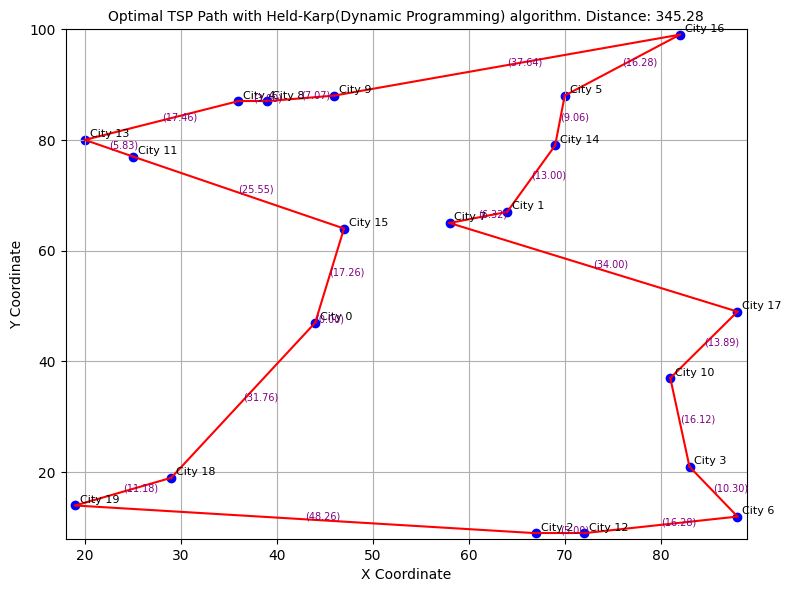

------------------------------------------------Algorithm options------------------------------------------------
 1. Brute Force
 2. Branch and Bound
 3. Dynamic Programming(Held-Karp)
 4. Genetic Algorithm
 5. Nearest-Neighbor
Generation 0 - Best Distance: 705.143687421966
Generation 50 - Best Distance: 371.24676120755686
Generation 100 - Best Distance: 367.7983748743165
Generation 150 - Best Distance: 348.5135206198474
Generation 200 - Best Distance: 345.2808560945127
Generation 250 - Best Distance: 345.2808560945127
Generation 300 - Best Distance: 345.2808560945127
Generation 350 - Best Distance: 345.2808560945127
Generation 400 - Best Distance: 345.2808560945127
Generation 450 - Best Distance: 345.2808560945127
Selected << Genetic algorithm>>
Optimal Path: [17, 7, 1, 14, 5, 16, 9, 8, 4, 13, 11, 15, 0, 18, 19, 2, 12, 6, 3, 10]
Optimal Distance: 345.28
Optimal Path: [17, 7, 1, 14, 5, 16, 9, 8, 4, 13, 11, 15, 0, 18, 19, 2, 12, 6, 3, 10], Optimal Distance: 345.2808560945127
Time Take 

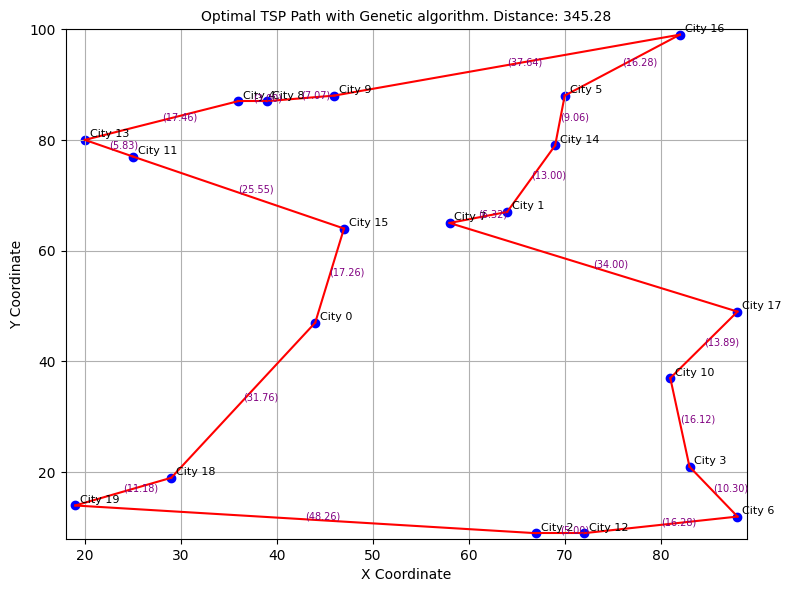

------------------------------------------------Algorithm options------------------------------------------------
 1. Brute Force
 2. Branch and Bound
 3. Dynamic Programming(Held-Karp)
 4. Genetic Algorithm
 5. Nearest-Neighbor
Selected << Nearest-Neighbor algorithm>>
Optimal Path: [0, 15, 7, 1, 14, 5, 16, 9, 8, 4, 11, 13, 18, 19, 2, 12, 3, 6, 10, 17]
Optimal Distance: 377.95
Optimal Path: [0, 15, 7, 1, 14, 5, 16, 9, 8, 4, 11, 13, 18, 19, 2, 12, 3, 6, 10, 17], Optimal Distance: 377.9521972394068
Time Take for execution: 0:00:00.000999


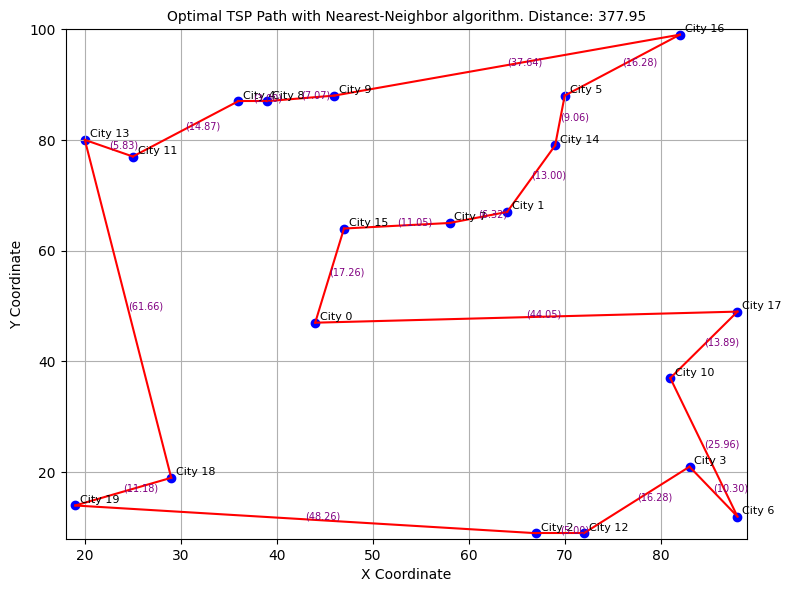

------------------------------------------------Algorithm options------------------------------------------------
 1. Brute Force
 2. Branch and Bound
 3. Dynamic Programming(Held-Karp)
 4. Genetic Algorithm
 5. Nearest-Neighbor
Exiting Program!!, Bye.
---Program initalization---
Program Input options 
 1.Custom Input
 2. Predefined input(Counter Example case)

30  random coordinates generated. Ready to Run.
------------------------------------------------Algorithm options------------------------------------------------
 1. Brute Force
 2. Branch and Bound
 3. Dynamic Programming(Held-Karp)
 4. Genetic Algorithm
 5. Nearest-Neighbor


In [84]:
# Solve the TSP
def main():
  while True:
    print("---Program initalization---")
    print("Program Input options \n 1.Custom Input\n 2. Predefined input(Counter Example case)\n")
    option1 = input("Type the desired option number to set data, press others to exit.")

    number_of_cities = ""
    coordinates = ""

    if option1 == "1":
      number_of_cities = input("Enter number of cities")
      number_of_cities = int(number_of_cities)
      # randomly generate coordinates for each city
      coordinates = np.random.randint(0, 100, (number_of_cities, 2))
      print(number_of_cities," random coordinates generated. Ready to Run.")
    elif option1 == "2":
      coordinates = np.array([
        [0, 0],
        [10, 0],
        [20, 0],
        [30, 0],
        [40, 0],
        [50, 0],
        [60, 0],
        [70, 0],
        [80, 0],
        [90, 0]
      ])
    else:
      print("Exiting Program!!, Bye.")
      break

    optimal_path = ""
    optimal_distance = ""
    title = ""

    while True:
      print("------------------------------------------------Algorithm options------------------------------------------------\n 1. Brute Force\n 2. Branch and Bound\n 3. Dynamic Programming(Held-Karp)\n 4. Genetic Algorithm\n 5. Nearest-Neighbor")
      option = input("Type the desired option number to select the algorithm of choice, press any key to reinitialise the data or to exit.")

      startTime = ""
      endTime = ""

      if option == "1":
        #BruteForce
        title = "Brute Force"
        startTime = datetime.datetime.now()
        optimal_path, optimal_distance = tsp_brute_force(coordinates)
        endTime = datetime.datetime.now()
      elif option == "2":
        #Branch and Bound
        title = "Branch and Bound"
        startTime = datetime.datetime.now()
        optimal_path, optimal_distance = tsp_branch_and_bound(coordinates)
        endTime = datetime.datetime.now()
      elif option == "3":
        #Held-Karp(Dynamic Programming)
        title = "Held-Karp(Dynamic Programming)"
        startTime = datetime.datetime.now()
        optimal_path, optimal_distance = tsp_held_karp(coordinates)
        endTime = datetime.datetime.now()
      elif option == "4":
        #Genetic Algorithm
        title = "Genetic"
        startTime = datetime.datetime.now()
        optimal_path, optimal_distance = genetic_algorithm(coordinates, pop_size=100, generations=500, mutation_rate=0.01)
        endTime = datetime.datetime.now()
      elif option == "5":
        #Nearest-Neighbor
        title = "Nearest-Neighbor"
        startTime = datetime.datetime.now()
        optimal_path, optimal_distance = tsp_nearest_neighbor(coordinates)
        endTime = datetime.datetime.now()
      else:
        print("Exiting Program!!, Bye.")
        break
      print(f"Selected << {title} algorithm>>")
      print(f"Optimal Path: {optimal_path}")
      print(f"Optimal Distance: {optimal_distance:.2f}")

      
      if optimal_path:
          print(f"Optimal Path: {optimal_path}, Optimal Distance: {optimal_distance}")
      print("Time Take for execution:", endTime-startTime)

      # Plot the result
      plot_tsp_path(optimal_path, optimal_distance, coordinates, title)
    
main()
